In [1]:
from TCSPC import *

In [2]:
EGFP = Simulation([0.497,0.503],[2.43,3.07])

In [3]:
# tdata = np.loadtxt('EGFPt.csv')
# ydata = np.loadtxt('EGFPy2.csv')

In [4]:
def trim_rescale_data(tdata,ydata,end =int(0.6*380),rescale = True):
    max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
    tdata = tdata[:end-max_idx] #start from t = 0
    ydata = ydata[max_idx:end]  #start from max.
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

In [5]:
def exp(t, A, tau):
    return A * np.exp(-t/tau)

In [6]:
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2)

In [7]:
def poisson_deviance_residual(observed, expected):
    # Ensure no invalid values
    # valid = (observed > 0) & (expected > 0)
    # residual = np.zeros_like(observed)
    # residual[valid] =  2 *  (observed[valid] * np.log(observed[valid] / expected[valid]) - (observed[valid] - expected[valid]))
    residual=  np.sqrt(abs(2 *  (observed* np.log(observed/ expected) - (observed- expected)))) #residual array
    return residual

def residual(p, t, data):
    v = p.valuesdict()
    generative = v['c'] #constant background
    M = 1
    while f'A{M}' in v:
        generative += exp(t, v[f'A{M}'], v[f'tau{M}'])
        M += 1
    
    return poisson_deviance_residual(data, generative) #lmfit.minimizer minimize the residual array in the sum of squared sense


In [8]:
def initial_params(M,A_guess,tau_guess,rescale = True):
    p = lmfit.Parameters()
    p.add_many(('c', 0, True, 0, 1)) #constant background
    for i in range(1,M+1): #for each component
        p.add_many((f'A{i}', A_guess[i-1], True,0), #amplitude
                   (f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    if rescale == True:
        p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p



### bi-exp decay fit to EGFP

In [9]:
EGFP.n_photon = int(1e6)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2,end = int(0.5*380))
p1 = initial_params(2,EGFP.amp,EGFP.tau)
#p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method='powell')

print(lmfit.fit_report(mi1))


[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 422
    # data points      = 180
    # variables        = 4
    chi-square         = 0.01097018
    reduced chi-square = 6.2331e-05
    Akaike info crit   = -1738.99567
    Bayesian info crit = -1726.22384
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     1.4254e-05 (init = 0)
    A1:    0.49767473 (init = 0.497)
    tau1:  2.37237077 (init = 2.43)
    A2:    0.50232527 == '1 - A1'
    tau2:  3.14481800 (init = 3.07)


In [10]:
result = mi1
del result.params['A2']

In [13]:
info_df,par_df = fit_df([result])

AttributeError: 'NoneType' object has no attribute 'items'

In [14]:
par_df

NameError: name 'par_df' is not defined

### No rescale

In [119]:
EGFP.n_photon = int(1e4)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2,end = 100,rescale = False)
p1 = initial_params(2,[np.max(EGFP.y2*0.49),np.max(EGFP.y2)*0.51],EGFP.tau,rescale = False)
#p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi1))



[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 203
    # data points      = 81
    # variables        = 5
    chi-square         = 86.4451956
    reduced chi-square = 1.13743678
    Akaike info crit   = 15.2699800
    Bayesian info crit = 27.2422257
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     0.89807906 (init = 0)
    A1:    61.4692773 (init = 97.02)
    tau1:  1.98470819 (init = 2.43)
    A2:    105.865779 (init = 100.98)
    tau2:  2.87943731 (init = 3.07)


### mono-exp decay fit to EGFP

In [120]:
p1

name,value,initial value,min,max,vary
c,0.00000000,0,0.00000000,1.00000000,True
A1,97.0200000,97.02,0.00000000,inf,True
tau1,2.43000000,2.43,0.00000000,inf,True
A2,100.980000,100.98,0.00000000,inf,True
tau2,3.07000000,3.07,0.00000000,inf,True


In [121]:
EGFP.n_photon = int(1e4)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2,end = 100,rescale = False)
p1 = initial_params(3,[np.max(EGFP.y2*0.49),np.max(EGFP.y2)*0.51,1],EGFP.tau+[1],rescale = False)
#p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 279
    # data points      = 86
    # variables        = 7
    chi-square         = 70.7713077
    reduced chi-square = 0.89583934
    Akaike info crit   = -2.76085276
    Bayesian info crit = 14.4195783
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     0.06266400 (init = 0)
    A1:    76.7308020 (init = 95.06)
    tau1:  2.48193622 (init = 2.43)
    A2:    98.1584590 (init = 98.94)
    tau2:  3.09700754 (init = 3.07)
    A3:    5.8109e-06 (init = 1)
    tau3:  3749860.70 (init = 1)


In [122]:
np.sum(residual(mi1.params,tdata,ydata))

61.90819236228194

## Get 100 simulation at each point (bi-exp decay)


In [96]:
def MLEfit(N,tdata,ydata,method ='powell',end=100,rescale=False):

    tdata, ydata, weights = trim_rescale_data(tdata,ydata, end=end, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)
MLEfit(2,EGFP.t,EGFP.sim_data[0])

,c,A1,tau1,A2,tau2
0,1.0,0.489309,2.418512,0.510691,3.07887


In [97]:
def MLEfit(N,tdata,ydata,method ='powell',end=100,rescale=False):

    tdata, ydata, weights = trim_rescale_data(tdata,ydata, end=end, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)

def val_df():
  '''Create dataframe of fitted parameters'''
  df_list = []
  for j in range(100):
    df_list.append( MLEfit(N,EGFP.t,EGFP.sim_data[j]))
    df= pd.concat(df_list).reset_index()
  return df.drop(['index'],axis =1)

N=2 #components
EGFP.y_list = np.zeros((20,100,380))
n_photon_arr = np.logspace(4,9,20)
df_list = []
for i in range(len(n_photon_arr)):
  EGFP.n_photon = n_photon_arr[i]
  EGFP.repeat_sim(100)
  EGFP.y_list[i] = EGFP.sim_data
  df =val_df()
  df_list.append(df)


In [98]:
df = val_df()

In [99]:
n_val_df =pd.concat(df_list,keys = range(20))

Text(0.5, 1.0, 'EGFP at low photon number')

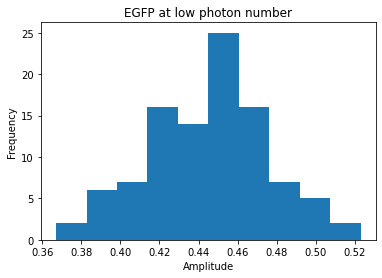

In [123]:
plt.hist(n_val_df.loc[0,'A1']) # at low phton number
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('EGFP at low photon number')

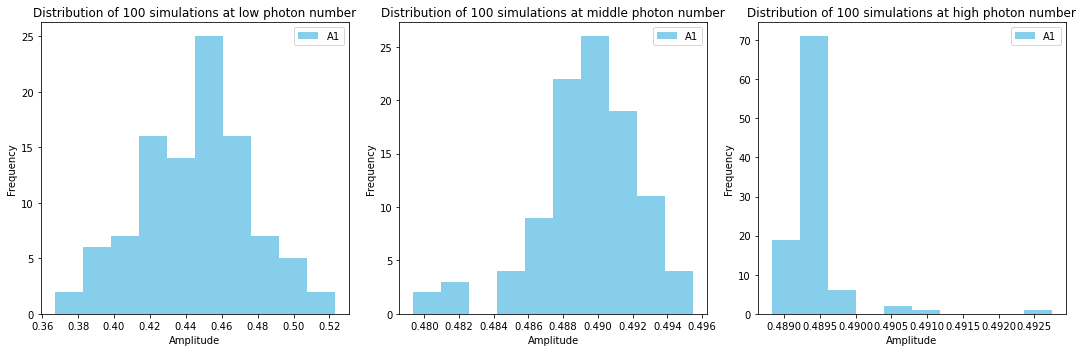

In [135]:
# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot histogram for low photon number
axs[0].hist(n_val_df.loc[0, 'A1'], bins=10, color='skyblue')  # Adjust bins if needed
axs[0].set_xlabel('Amplitude')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of 100 simulations at low photon number')
axs[0].legend(['A1'])

# Plot histogram for middle photon number
axs[1].hist(n_val_df.loc[10, 'A1'], bins=10, color='skyblue')  # Adjust bins if needed
axs[1].set_xlabel('Amplitude')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of 100 simulations at middle photon number')
axs[1].legend(['A1'])

# Plot histogram for high photon number
axs[2].hist(n_val_df.loc[19, 'A1'], bins=10, color='skyblue')  # Adjust bins if needed
axs[2].set_xlabel('Amplitude')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of 100 simulations at high photon number')
axs[2].legend(['A1'])

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [136]:
mean_df = n_val_df.groupby(level=0).mean()
std_df = n_val_df.groupby(level=0).std()

In [137]:
mean_df

,c,A1,tau1,A2,tau2
0,0.438396,0.445722,2.306707,0.554278,3.088050
1,0.457191,0.460775,2.342729,0.539225,3.109895
2,0.494805,0.479499,2.404276,0.520501,3.078916
3,0.520850,0.480303,2.390817,0.519697,3.091688
4,0.476378,0.485163,2.424226,0.514837,3.067746
5,0.601328,0.486806,2.400056,0.513194,3.097217
6,0.534886,0.489471,2.417469,0.510529,3.078255
7,0.565020,0.489602,2.424690,0.510398,3.071649
8,0.597807,0.490139,2.435257,0.509861,3.063236
9,0.562035,0.490103,2.427178,0.509897,3.071703


In [138]:
std_df

,c,A1,tau1,A2,tau2
0,0.426693,0.031083,0.304437,0.031083,0.289021
1,0.411329,0.024480,0.214468,0.024480,0.238547
2,0.419077,0.024755,0.185588,0.024755,0.221092
3,0.421965,0.015924,0.174007,0.015924,0.190066
4,0.448084,0.012141,0.154644,0.012141,0.167218
5,0.439453,0.008996,0.122176,0.008996,0.134554
6,0.453690,0.008512,0.144355,0.008512,0.149439
7,0.438708,0.008247,0.134502,0.008247,0.138683
8,0.413006,0.009929,0.122222,0.009929,0.123503
9,0.461109,0.004101,0.061983,0.004101,0.063644


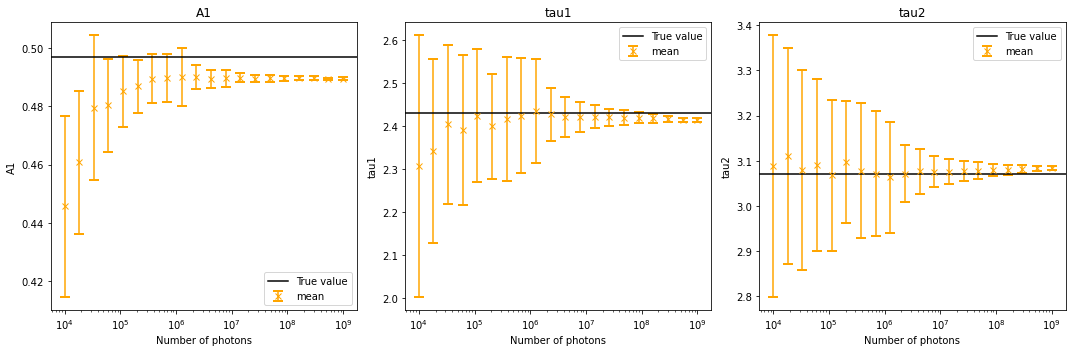

In [139]:
# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# A1 plot
axs[0].errorbar(n_photon_arr, mean_df['A1'], yerr=std_df['A1'], fmt='x', ecolor='orange', capthick=2,
                capsize=5, color='orange', label='mean')
axs[0].axhline(y=0.497, color='k', linestyle='-', label='True value')
axs[0].set_xscale('log')
axs[0].set_xlabel('Number of photons')
axs[0].set_ylabel('A1')
axs[0].set_title('A1')
axs[0].legend()

# tau1 plot
axs[1].errorbar(photon_numbers, mean_df['tau1'], yerr=std_df['tau1'], fmt='x', ecolor='orange', capthick=2,
                capsize=5, color='orange', label='mean')
axs[1].axhline(y=2.43, color='k', linestyle='-', label='True value')
axs[1].set_xscale('log')
axs[1].set_xlabel('Number of photons')
axs[1].set_ylabel('tau1')
axs[1].set_title('tau1')
axs[1].legend()

# tau2 plot
axs[2].errorbar(photon_numbers, mean_df['tau2'], yerr=std_df['tau2'], fmt='x', ecolor='orange', capthick=2,
                capsize=5, color='orange', label='mean')
axs[2].axhline(y=3.07, color='k', linestyle='-', label='True value')
axs[2].set_xscale('log')
axs[2].set_xlabel('Number of photons')
axs[2].set_ylabel('tau2')
axs[2].set_title('tau2')
axs[2].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [140]:
par_dict = {k:v.value for k,v in mi1.params.items()}
A_sum = sum([par_dict[f'A{j}'] for j in range(1,N+1)])
for i in range(1,N+1):
  par_dict[f'A{i}']=par_dict[f'A{i}']/A_sum

In [141]:
par_dict

{'c': 0.06266399720935933,
 'A1': 0.43873935753300397,
 'tau1': 2.4819362211337666,
 'A2': 0.561260642466996,
 'tau2': 3.097007535851029,
 'A3': 5.810865297606327e-06,
 'tau3': 3749860.6963326423}